## Hard Drive Implementation

In [2]:
%matplotlib inline
import os
from os import path
import shutil
import datetime as dt
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [ ]:
#Iterate through ever directory on the hard drive with ending '_SOON_All' and run algorithm 
for direc in os.listdir('/Volumes/SOONAR DATA'):
    if (direc.startswith('2013-06-2') and direc.endswith('_SOON_All') and not direc.startswith('2013-06-20') and not direc.startswith('2013-06-21')):
            print('/Volumes/SOONAR DATA'+'/'+direc)
            create_temp_files('/Volumes/SOONAR DATA'+'/'+direc)
print('convert .pkl to .FIT')
convert_SOONAR_dir()

In [ ]:
def create_temp_files(folder):
    file_count = 0
    directory = os.fsencode(folder)
    #If directory SOONAR is not created
    if not os.path.exists('/Volumes/SOONAR DATA/SOONAR'):
        #create SOONAR direcotry
        os.makedirs('/Volumes/SOONAR DATA/SOONAR')
    #Iterate through .fit files in initial folder
    for file in os.listdir(directory):
        target_folder = '/Volumes/SOONAR DATA/SOONAR'
        filename = os.fsdecode(file)
        if filename.endswith(".FIT"):
            #Extract image, header, date, and time data
            FITS_file = folder+'/'+filename
            image_data = fits.getdata(FITS_file, ext=0)
            hdr = fits.open(FITS_file)[0].header
            date_str = hdr['DATE-OBS']
            time_str = hdr['TIME-OBS']
            date_time = dt.datetime.strptime(date_str+' '+time_str, '%Y-%m-%d %H:%M:%S')
            #If year folder is not created
            if not os.path.exists(target_folder+'/'+date_str[0:4]):
                #create year folder
                os.makedirs(target_folder+'/'+date_str[0:4])
            #If month folder is not created
            if not os.path.exists(target_folder+'/'+date_str[0:4]+'/'+date_str[5:7]+date_time.strftime('%b').upper()):
                #create month folder
                os.makedirs(target_folder+'/'+date_str[0:4]+'/'+date_str[5:7]+date_time.strftime('%b').upper())
            #If day folder is not created
            if not os.path.exists(target_folder+'/'+date_str[0:4]+'/'+date_str[5:7]+date_time.strftime('%b').upper()+'/'+date_str[8:10]):
                #create day folder
                os.makedirs(target_folder+'/'+date_str[0:4]+'/'+date_str[5:7]+date_time.strftime('%b').upper()+'/'+date_str[8:10])
            #Set target_folder to created directory
            target_folder = target_folder+'/'+date_str[0:4]+'/'+date_str[5:7]+date_time.strftime('%b').upper()+'/'+date_str[8:10]
            #If new solar region-observatory combination
            temp_name = hdr['OBJECT']+'-'+hdr['ORIGIN'][0:4]
            target_file = target_folder+'/'+temp_name+'.pkl'
            if not os.path.exists(target_file):
                #Create temporary .pkl file holding (unsorted) date_time, header, and image_data for that solar region-observatory combination
                save_file = open(target_file, 'wb')
                pickle.dump([[date_time], [hdr], [image_data]], save_file)
                save_file.close()
            else:
                #Add and save date_time, header, and image_data to existing temporary .pkl file for given solar region-observatory combination
                open_file = open(target_file, 'rb')
                open_array = pickle.load(open_file)
                open_file.close()
                dt_array = open_array[0]
                hdr_array = open_array[1]
                id_array = open_array[2]
                dt_array.append(date_time)
                hdr_array.append(hdr)
                id_array.append(image_data)
                save_file = open(target_file, 'wb')
                pickle.dump([dt_array, hdr_array, id_array], save_file)
                save_file.close()
            #Troubleshooting Output
            file_count += 1
            print(str(file_count)+') ' +filename)
            #print(date_time)
            #print(temp_name)

In [ ]:
def convert_SOONAR_dir():
    #For every file (recusive) in SOONAR directory
    for subdir, dirs, files in os.walk('/Volumes/SOONAR DATA/SOONAR'):
        for file in files:
            target_folder = subdir + os.sep
            target_file = subdir + os.sep + file
            #If it is a .npy file
            if (target_file.endswith(".pkl")):
                print(target_file)
                #Extract data (as a list)
                open_file = open(target_file, 'rb')
                open_array = pickle.load(open_file)
                open_file.close()
                dt_array = open_array[0]
                hdr_array = open_array[1]
                id_array = open_array[2]
                #Sort data
                sorted_array = sorted (zip (dt_array, hdr_array, id_array), key=lambda x: x[0])
                #Write sorted data to a .fit file
                write_to_fits(target_folder+'/'+sorted_array[0][0].strftime('%H%M')+'-'+sorted_array[-1][0].strftime('%H%M')+'-'+file[0:9]+'.FIT', sorted_array)
                #Delete .pkl file
                os.remove(target_file)

In [ ]:
def write_to_fits (target_loc, sorted_array):
    #Create HDUL(ist)
    new_hdul = fits.HDUList()
    #Add (sorted) images to the .fit file
    for i in range(0,len(sorted_array)):
        new_hdul.append(fits.ImageHDU(sorted_array[i][2], sorted_array[i][1]))
    new_hdul.writeto(target_loc, overwrite = True, output_verify = "fix")

## Testing

In [ ]:
FITS_file_test = '/Volumes/SOONAR DATA/SOONAR/2013/06JUN/18/1209-1724-1767-SANV.FIT'
fits.info(FITS_file_test)
image_data_test = fits.getdata(FITS_file_test, ext=37)
hdr_test = fits.open(FITS_file_test)[37].header
print(hdr_test)
plt.imshow(image_data_test)

/Volumes/SOONAR FAST/2013-10-09_SOON_All/LISS131009145313IM2.FIT

In [ ]:
for subdir, dirs, files in os.walk('/Volumes/SOONAR FAST'):
    for file in files:
        target_file = subdir + os.sep + file
        if (target_file.endswith(".FIT")):
            FITS_file = target_file
            try:
                image_data = fits.getdata(FITS_file, ext=0)
                hdr = fits.open(FITS_file)[0].header
            except TypeError:
                print(FITS_file)
                os.remove(FITS_file)

Filename: /Users/jeparker/Desktop/2029-2358-1769-HOLL.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   (512, 512)   uint8   
  1                1 ImageHDU        70   (512, 512)   uint8   
  2                1 ImageHDU        70   (512, 512)   uint8   
  3                1 ImageHDU        70   (512, 512)   uint8   
  4                1 ImageHDU        70   (512, 512)   uint8   
  5                1 ImageHDU        70   (512, 512)   uint8   
  6                1 ImageHDU        70   (512, 512)   uint8   
  7                1 ImageHDU        70   (512, 512)   uint8   
  8                1 ImageHDU        70   (512, 512)   uint8   
  9                1 ImageHDU        70   (512, 512)   uint8   
 10                1 ImageHDU        70   (512, 512)   uint8   
 11                1 ImageHDU        70   (512, 512)   uint8   
 12                1 ImageHDU        70   (512, 512)   uint8   
 13                1 ImageHDU        70   (512, 

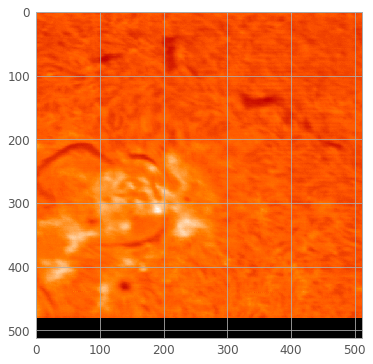

In [33]:
FITS_file_test = path.expanduser('~/Desktop/2029-2358-1769-HOLL.FIT')
fits.info(FITS_file_test)
image_data_test = fits.getdata(FITS_file_test, ext=17)
hdr_test = fits.open(FITS_file_test)[17].header
print(hdr_test)
plt.imshow(image_data_test)

In [ ]:
FITS_file_test = '/Volumes/SOONAR DATA/SOONAR/2013/06JUN/18/1209-1724-1767-SANV.FIT'
fits.info(FITS_file_test)
image_data_test = fits.getdata(FITS_file_test, ext=37)
hdr_test = fits.open(FITS_file_test)[37].header
print(hdr_test)
plt.imshow(image_data_test)

In [3]:
for file in os.listdir('/Volumes/SOONAR FAST/Broken Files'):
    if file.endswith('.FIT'):
        FITS_file = file
        try:
            image_data = fits.getdata(FITS_file, ext=0)
            hdr = fits.open(FITS_file)[0].header
        except(TypeError):
            print('TypeError ' + FITS_file)
        except(OSError):
            print('OSError ' + FITS_file)

OSError APLM170630055147IM2.FIT
OSError APLM150622080104IM2.FIT
OSError KHMN150801200411IM2.FIT
OSError KHMN160815135729IM2.FIT
OSError APLM151024070317IM2.FIT
OSError APLM150710012054IM2.FIT
OSError APLM170730062650IM2.FIT
OSError APLM150622080014IM2.FIT
OSError APLM170408000954IM2.FIT
OSError LISS160505093109IM2.FIT
OSError APLM170804085806IM2.FIT
OSError APLM160311233156IM2.FIT
OSError APLM150622082139IM2.FIT
OSError LISS160815135701IM2.FIT
OSError APLM150710012040IM2.FIT
OSError LISS151127072545IM2.FIT
OSError KHMN160815135731IM2.FIT
OSError APLM170408000749IM2.FIT
OSError APLM160311233224IM2.FIT
OSError APLM151024070126IM2.FIT
OSError APLM170730062644IM2.FIT
OSError APLM150710011714IM2.FIT
OSError APLM151024070316IM2.FIT
OSError APLM150622082544IM2.FIT
OSError KHMN150204183410IM2.FIT
OSError APLM150622080109IM2.FIT
OSError APLM151024082337IM2.FIT
OSError APLM170630055228IM2.FIT
OSError APLM160311233153IM2.FIT
OSError APLM151024070318IM2.FIT
OSError APLM151024082317IM2.FIT
OSError 